# Setup

In [1]:
import json
import os
import sys
import warnings

sys.path.append('..')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import GroupKFold, KFold
from sklearn.metrics import balanced_accuracy_score, recall_score, mean_absolute_error, root_mean_squared_error
from sklearn.linear_model import ElasticNetCV, LogisticRegressionCV
from sklearn.dummy import DummyRegressor

from verde import BlockKFold

from pymer4 import Lmer
from flaml import AutoML

from utils import read_csv_non_utf
from model_utils import HurdleModelEstimator, PymerModelWrapper
from custom_metrics import balanced_accuracy_FLAML, mean_absolute_error_range
from cross_validation import run_cross_val, save_cv_results

In [2]:
# Loading in general configuration
with open('../config.json', 'r') as f:
    config = json.load(f)

# Getting filepaths
gdrive_fp = config['gdrive_path']
LIFE_fp = config['LIFE_folder']
dataset_fp = config['datasets_path']
benitez_lopez2019 = config['indiv_data_paths']['benitez_lopez2019']

data_path = os.path.join(gdrive_fp, LIFE_fp, dataset_fp, benitez_lopez2019)

In [3]:
# Reading in data as a pandas dataframe
ben_lop2019 = read_csv_non_utf(data_path)

# Running the cross-validation

In [4]:
# Defining the metrics to use
class_metrics = {'per_class' : {'balanced_accuracy' : {'function' : balanced_accuracy_score,
                                                       'kwargs' : {}
                                                      },
                                'sensitivity' : {'function' : recall_score,
                                                 'kwargs' : {'pos_label' : 1}
                                                 },
                                'specificity' : {'function' : recall_score,
                                                 'kwargs' : {'pos_label' : 0}
                                                 }
                               },
                  'overall' : {'balanced_accuracy_overall' : {'function' : balanced_accuracy_score,
                                                              'kwargs' : {}
                                                             }
                              }
                }
reg_metrics = {'mean_absolute_error' : {'function' : mean_absolute_error,
                                        'kwargs' : {}
                                       },
               'root_mean_squared_error' : {'function' : root_mean_squared_error,
                                            'kwargs' : {}
                                           },
               'mean_absolute_error_0-1' : {'function' : mean_absolute_error_range,
                                            'kwargs' : {'lower_bound' : 0,
                                                        'upper_bound' : 1
                                                       }
                                           }
              }

In [7]:
# Choosing the model to use, among pymer, sklearn, FLAML_hurdle, FLAML_regression, FLAML_classification
model_to_use = 'dummy_regressor'

# General cross-validation params
num_folds = 5
block_type = None
group_col = None
spatial_spacing = 5

# Pymer hurdle model, for sanity checking
if model_to_use == 'pymer':
    #  setting up the equations for each model
    formula_zero = 'local_extirpation ~ BM + DistKm + I(DistKm^2) + PopDens + Stunting + Reserve + (1|Country) + (1|Species) + (1|Study)'
    formula_nonzero = 'RR ~ BM + DistKm + I(DistKm^2) + PopDens + I(PopDens^2) + BM*DistKm + (1|Country) + (1|Species) + (1|Study)'
    control_str = "optimizer='bobyqa', optCtrl=list(maxfun=1e5)"

    #  hurdle model params
    use_rfx = True
    extirp_pos = False

    #  setting up the hurdle model
    zero_model = PymerModelWrapper(Lmer, formula = formula_zero, family = 'binomial', control_str = control_str, 
                                   use_rfx = use_rfx)
    nonzero_model = PymerModelWrapper(Lmer, formula = formula_nonzero, family = 'gaussian', use_rfx = use_rfx)
    model = HurdleModelEstimator(zero_model, nonzero_model, extirp_pos = extirp_pos, 
                                 data_args = {'outlier_cutoff' : 15})

    #  cross-validation params
    back_transform = True
    sklearn_submodels = False
    direct = None
    tune_hurdle_thresh = True
    
    fit_args = None
    pp_args = {'include_indicators' : False,
               'include_categorical' : True,
               'polynomial_features' : 0,
               'log_trans_cont' : True}

    #  results saving params
    model_name = 'pymer_hurdle'
    model_name += '_w_rfx' if use_rfx else '_wo_rfx'
    
# Sklearn fixed-effects hurdle model
elif model_to_use == 'sklearn':
    #  hurdle model params
    extirp_pos = False
    verbose = False
    
    indicator_columns = ['Diet']
    nonzero_columns = ['BM', 'DistKm', 'PopDens', 'Stunting', 'TravTime', 'LivestockBio', 'Literacy', 'Reserve']
    zero_columns = nonzero_columns
    data_args = {'indicator_columns' : indicator_columns,
                 'nonzero_columns' : nonzero_columns,
                 'zero_columns' : zero_columns}

    #  cross-validation params for tuning zero/nonzero model hyperparams
    grid_cv = 5
    logistic_penalty = 'l1'
    l1_ratio = [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 1]
    Cs = 20

    #  setting up the hurdle model
    nonzero_model = ElasticNetCV(cv = grid_cv, l1_ratio = l1_ratio, max_iter = 5000)
    zero_model = LogisticRegressionCV(cv = grid_cv, Cs = Cs, penalty = logistic_penalty, solver = 'saga', max_iter = 500)
    model = HurdleModelEstimator(zero_model, nonzero_model, extirp_pos = extirp_pos, verbose = verbose,
                                 data_args = data_args)

    #  cross-validation params
    back_transform = True
    sklearn_submodels = True
    direct = None
    tune_hurdle_thresh = True
    
    fit_args = None
    pp_args = {'include_indicators' : False,
               'include_categorical' : False,
               'polynomial_features' : 2,
               'log_trans_cont' : False}
    
    #  results saving params
    model_name = 'sklearn_hurdle'

# FLAML AutoML hurdle model
elif model_to_use == 'FLAML_hurdle':
    #  automl params
    time_budget_mins = 2
    base_path = os.path.join('..', 'model_saves')
    
    zero_metric = balanced_accuracy_FLAML
    nonzero_metric = 'mse'

    #  hurdle model params
    verbose = 0
    extirp_pos = False
    
    zero_columns = ['BM', 'DistKm', 'PopDens', 'Stunting', 'TravTime', 'LivestockBio', 'Literacy', 'Reserve']
    nonzero_columns = zero_columns
    indicator_columns = []
    
    #  setting up the zero and nonzero models
    zero_model = AutoML()
    nonzero_model = AutoML()
    
    #  specify fitting paramaters
    zero_settings = {
        'time_budget' : time_budget_mins * 60,  # in seconds
        'metric' : zero_metric,
        'task' : 'classification',
        'log_file_name' : os.path.join(base_path, f'nonlinear_hurdle.log'),
        'seed' : 1693,
        'estimator_list' : ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'kneighbor', 'lrl1', 'lrl2'],
        'early_stop' : True,
        'verbose' : verbose,
        'keep_search_state' : True
    }
    
    nonzero_settings = {
        'time_budget' : time_budget_mins * 60,  # in seconds
        'metric' : nonzero_metric,
        'task' : 'regression',
        'log_file_name' : os.path.join(base_path, f'nonlinear_hurdle.log'),
        'seed' : 1693,
        'estimator_list' : ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'kneighbor'],
        'early_stop' : True,
        'verbose' : verbose,
        'keep_search_state' : True
    }
    
    #  dumping everything into the hurdle model wrapper
    data_args = {'indicator_columns' : indicator_columns,
                 'nonzero_columns' : nonzero_columns,
                 'zero_columns' : zero_columns}
    model = HurdleModelEstimator(zero_model, nonzero_model, extirp_pos = extirp_pos, 
                                 data_args = data_args, verbose = False)

    #  cross-validation params
    back_transform = True
    sklearn_submodels = False
    direct = None
    tune_hurdle_thresh = True
    
    fit_args = {'zero' : zero_settings, 'nonzero' : nonzero_settings}
    pp_args = {'include_indicators' : False,
               'include_categorical' : False,
               'polynomial_features' : 0,
               'log_trans_cont' : False}

    #  results saving params
    model_name = f'FLAML_hurdle_{time_budget_mins}mins'

# FLAML AutoML direct regression model
elif model_to_use == 'FLAML_regression':
    #  initialize automl instance
    model = AutoML()
    
    #  specify paramaters
    time_budget_mins = 2
    base_path = os.path.join('..', 'model_saves', f'direct_regression')
    
    automl_settings = {
        'time_budget' : time_budget_mins * 60,  # in seconds
        'metric' : 'mse',
        'task' : 'regression',
        'log_file_name' : os.path.join(base_path, f'mammals_direct_regression.log'),
        'seed' : 1693,
        'estimator_list' : ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'kneighbor'],
        'early_stop' : True,
        'verbose' : 0
    }

    #  cross-validation params
    back_transform = False
    sklearn_submodels = False
    direct = 'regression'
    tune_hurdle_thresh = False

    fit_args = automl_settings
    pp_args = {'include_indicators' : False,
               'include_categorical' : False,
               'polynomial_features' : 0,
               'log_trans_cont' : False}

    #  results saving params
    model_name = f'FLAML_regression_{time_budget_mins}mins'

# FLAML AutoML direct classification model
elif model_to_use == 'FLAML_classification':
    #  initialize the automl instance
    model = AutoML()
    
    #  specify paramaters
    time_budget_mins = 2
    base_path = os.path.join('..', 'model_saves', f'direct_classification')
    
    automl_settings = {
        'time_budget' : time_budget_mins * 60,  # in seconds
        'metric' : balanced_accuracy_FLAML,
        'task' : 'classification',
        'log_file_name' : os.path.join(base_path, f'mammals_direct_classification.log'),
        'seed' : 1693,
        'estimator_list' : ['lgbm', 'xgboost', 'xgb_limitdepth', 'rf', 'extra_tree', 'kneighbor'],
        'early_stop' : True,
        'verbose' : 0
    }

    #  cross-validation params
    back_transform = False
    sklearn_submodels = False
    direct = 'classification'
    tune_hurdle_thresh = False
    reg_metrics = None

    fit_args = automl_settings
    pp_args = {'include_indicators' : False,
               'include_categorical' : False,
               'polynomial_features' : 0,
               'log_trans_cont' : False}

    #  results saving params
    model_name = f'FLAML_classification_{time_budget_mins}mins'

# Dummy regressor
elif model_to_use == 'dummy_regressor':
    strat = 'mean' # either mean or median
    model = DummyRegressor(strategy = strat)
    
    #  cross-validation params
    back_transform = False
    sklearn_submodels = False
    direct = 'regression'
    tune_hurdle_thresh = False

    fit_args = None
    pp_args = {'include_indicators' : False,
               'include_categorical' : False,
               'polynomial_features' : 0,
               'log_trans_cont' : False}

    #  results saving params
    model_name = 'dummy_regressor'

print(f'Using {model_name}')

all_metric_names = list(class_metrics['per_class']) + list(class_metrics['overall']) + (list(reg_metrics.keys()) if reg_metrics is not None else [])
print(f'Metrics: {all_metric_names}')

Using dummy_regressor
Metrics: ['balanced_accuracy', 'sensitivity', 'specificity', 'balanced_accuracy_overall', 'mean_absolute_error', 'root_mean_squared_error', 'mean_absolute_error_0-1']


In [8]:
# Run the cross-validation using the inputted params
metrics_dict = run_cross_val(model, ben_lop2019, block_type = block_type, num_folds = num_folds, 
                             group_col = group_col, spatial_spacing = spatial_spacing, fit_args = fit_args, 
                             pp_args = pp_args, class_metrics = class_metrics, reg_metrics = reg_metrics, 
                             verbose = True, random_state = 1693, sklearn_submodels = sklearn_submodels, 
                             back_transform = back_transform, direct = direct, tune_hurdle_thresh = tune_hurdle_thresh)

Using standard cross-validation
Fold 0:
  training model
  getting test metrics
Fold 1:
  training model
  getting test metrics
Fold 2:
  training model
  getting test metrics
Fold 3:
  training model
  getting test metrics
Fold 4:
  training model
  getting test metrics


In [9]:
# Saving and displaying results
save_fp = '/Users/emiliolr/Desktop/life-hunting/results'
cross_val_params = {'num_folds' : num_folds,
                    'block_type' : block_type,
                    'spatial_spacing' : spatial_spacing,
                    'group_col' : group_col}

save_cv_results(metrics_dict, model_name, save_fp, cross_val_params, class_metrics, reg_metrics)

,DI_category,metric,mean,standard_deviation,date,model_name,num_folds,block_type,spatial_spacing,group_col
1,high,balanced_accuracy,0.5,0.000000,2024-06-10 18:32:02,dummy_regressor,5,random,NaN,NaN
2,high,sensitivity,0.0,0.000000,2024-06-10 18:32:02,dummy_regressor,5,random,NaN,NaN
3,high,specificity,1.0,0.000000,2024-06-10 18:32:02,dummy_regressor,5,random,NaN,NaN
4,low,balanced_accuracy,0.5,0.000000,2024-06-10 18:32:02,dummy_regressor,5,random,NaN,NaN
5,low,sensitivity,1.0,0.000000,2024-06-10 18:32:02,dummy_regressor,5,random,NaN,NaN
6,low,specificity,0.0,0.000000,2024-06-10 18:32:02,dummy_regressor,5,random,NaN,NaN
7,medium,balanced_accuracy,0.5,0.000000,2024-06-10 18:32:02,dummy_regressor,5,random,NaN,NaN
8,medium,sensitivity,0.0,0.000000,2024-06-10 18:32:02,dummy_regressor,5,random,NaN,NaN
9,medium,specificity,1.0,0.000000,2024-06-10 18:32:02,dummy_regressor,5,random,NaN,NaN
10,overall,balanced_accuracy_overall,0.333333,0.000000,2024-06-10 18:32:02,dummy_regressor,5,random,NaN,NaN


# Plotting miscellaneous results

In [15]:
# Load back in cross-val resuls
cv_results = pd.read_csv(save_fp)

metrics_to_keep = ['balanced_accuracy_overall', 'mean_absolute_error', 'mean_absolute_error_0-1']
cv_results = cv_results[cv_results['metric'].isin(metrics_to_keep)]

cols_to_keep = ['metric', 'mean', 'standard_deviation', 'model_name', 'block_type', 'group_col']
cv_results = cv_results[cols_to_keep]

cv_results = cv_results.sort_values(by = ['block_type', 'model_name', 'metric'])
cv_results.head()

,metric,mean,standard_deviation,model_name,block_type,group_col
211,balanced_accuracy_overall,0.563585,0.010078,FLAML_classification_2mins,group,Species
159,balanced_accuracy_overall,0.508438,0.032240,FLAML_hurdle_2mins,group,Species
260,balanced_accuracy_overall,0.433360,0.025099,FLAML_hurdle_2mins,group,Study
299,balanced_accuracy_overall,0.482660,0.056114,FLAML_hurdle_2mins,group,Order
160,mean_absolute_error,0.807158,0.126454,FLAML_hurdle_2mins,group,Species


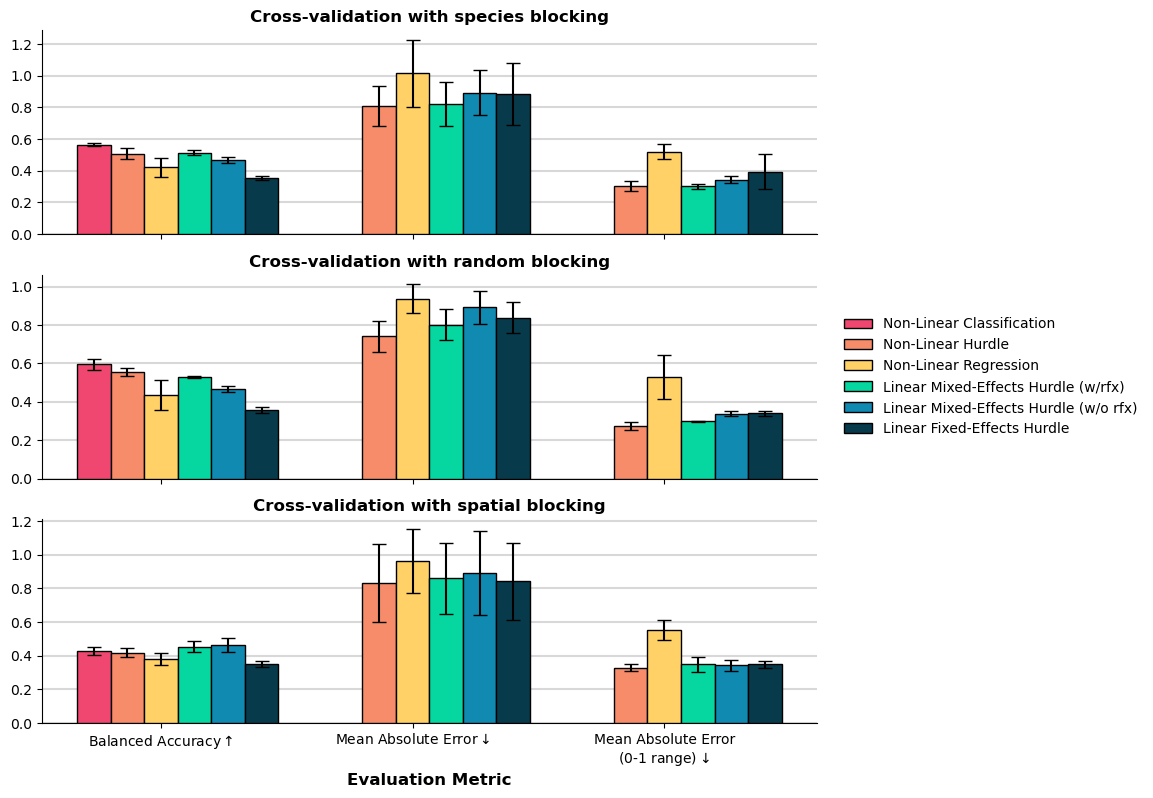

In [40]:
# Plotting results for the above metrics
width = 0.8

metrics = sorted(cv_results[cv_results['model_name'] == 'sklearn_hurdle']['metric'].unique())

model_names_plot = {'FLAML_classification_2mins' : 'Non-Linear Classification', 
                    'FLAML_regression_2mins' : 'Non-Linear Regression',
                    'sklearn_hurdle' : 'Linear Fixed-Effects Hurdle',
                    'pymer_hurdle_w_rfx' : 'Linear Mixed-Effects Hurdle (w/rfx)',
                    'pymer_hurdle_wo_rfx' : 'Linear Mixed-Effects Hurdle (w/o rfx)',
                    'FLAML_hurdle_2mins' : 'Non-Linear Hurdle'}
metric_names_plot = {'balanced_accuracy_overall' : 'Balanced Accuracy$\\uparrow$',
                     'mean_absolute_error' : 'Mean Absolute Error$\\downarrow$',
                     'mean_absolute_error_0-1' : 'Mean Absolute Error\n(0-1 range)$\\downarrow$',
                     'root_mean_squared_error' : 'Root Mean Squared Error$\\downarrow$'}

blocks = cv_results['block_type'].unique()
models = cv_results['model_name'].unique()
colors = ['#ef476f', '#f78c6b', '#ffd166', '#06d6a0', '#118ab2', '#073b4c']

fig, axs = plt.subplots(3, 1, figsize = (10, 9), sharex = True)

for i, block in enumerate(blocks):
    ax = axs[i]

    ind = np.arange(len(metrics))
    multiplier = 0
    
    for i, model in enumerate(models):
        model_results = cv_results[(cv_results['model_name'] == model) & (cv_results['block_type'] == block)]
        if block == 'group':
            model_results = model_results[model_results['group_col'] == 'Species']
        
        means = list(model_results['mean'])
        stds = list(model_results['standard_deviation'])
    
        if model.startswith('FLAML_classification'):
            means.extend([np.nan] * (len(metrics_to_keep) - 1))
            stds.extend([np.nan] * (len(metrics_to_keep) - 1))
    
        position = ind + (width / len(models)) * multiplier        
        ax.bar(position, means, width / len(models), yerr = stds, capsize = 5, edgecolor = 'black', 
               color = colors[i], label = model_names_plot[model], zorder = 100)
    
        multiplier += 1
    
    ax.set_xticks(ind + (width / 2) - (width / len(models)))
    ax.set_xticklabels([metric_names_plot[m] for m in metrics])

    block_name = 'species' if block == 'group' else block    
    ax.set_title(f'Cross-validation with {block_name} blocking', weight = 'bold', size = 12, pad = 6)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(visible = True, which = 'major', axis = 'y', color = 'grey', zorder = 0, linewidth = 1.5,
            alpha = 0.3)

axs[1].legend(loc = 'center right', bbox_to_anchor = (1.43, 0.5), ncols = 1, frameon = False)
plt.xlabel('Evaluation Metric', weight = 'bold', size = 12)

plt.savefig(f'../figures/cv_results_all_blocking.png', bbox_inches = 'tight', dpi = 300)
plt.show()

In [22]:
# Highlighting percent improvement in metrics betweeen non-linear vs. linear mixed effects (w/rfx) hurdle
cv_subset = cv_results[cv_results['model_name'].isin(['FLAML_hurdle_2mins', 'pymer_hurdle_wo_rfx'])]

for block in blocks:
    block_name = 'species' if block == 'group' else block  
    print(f'{block_name.upper()} BLOCKING')
    print('----------------')
    for metric in metrics_to_keep:
        mask = (cv_subset['metric'] == metric) & (cv_subset['block_type'] == block)
        if block == 'group':
            mask = mask & (cv_subset['group_col'] == 'Species')
       
        nonlinear_hurdle = cv_subset[mask & (cv_subset['model_name'] == 'FLAML_hurdle_2mins')]['mean'].iloc[0]
        linear_hurdle = cv_subset[mask & (cv_subset['model_name'] == 'pymer_hurdle_wo_rfx')]['mean'].iloc[0]
        
        pct_diff = round(((nonlinear_hurdle - linear_hurdle) / linear_hurdle) * 100, 2)
        if pct_diff > 0:
            pct_diff = '+' + str(pct_diff)
        print(f'{pct_diff}% for {metric}')
    print()

SPECIES BLOCKING
----------------
+8.55% for balanced_accuracy_overall
-9.64% for mean_absolute_error
-11.8% for mean_absolute_error_0-1

RANDOM BLOCKING
----------------
+18.47% for balanced_accuracy_overall
-16.96% for mean_absolute_error
-18.16% for mean_absolute_error_0-1

SPATIAL BLOCKING
----------------
-9.87% for balanced_accuracy_overall
-6.29% for mean_absolute_error
-4.19% for mean_absolute_error_0-1

